In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pyreadr
import yfinance as yf
import sqlite3
import plots as pl
import getFamaFrenchFactors as gff
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2022-12-31')

# Data

In [3]:
tidy_finance = sqlite3.connect(database="data/specialedata.sqlite")

### Macroeconomic predictors

In [ ]:
sheet_id = "1g4LOaRj4TvwJr9RIaA_nwrXXWTOy46bP"
sheet_name = "macro_predictors.xlsx"
macro_predictors_link = (
  f"https://docs.google.com/spreadsheets/d/{sheet_id}" 
  f"/gviz/tq?tqx=out:csv&sheet={sheet_name}"
)

macro_predictors = (
  pd.read_csv(macro_predictors_link, thousands=",")
  .assign(
    month=lambda x: pd.to_datetime(x["yyyymm"], format="%Y%m") + pd.offsets.MonthEnd(0),
    dp=lambda x: np.log(x["D12"])-np.log(x["Index"]),
    dy=lambda x: np.log(x["D12"])-np.log(x["D12"].shift(1)),
    ep=lambda x: np.log(x["E12"])-np.log(x["Index"]),
    de=lambda x: np.log(x["D12"])-np.log(x["E12"]),
    tms=lambda x: x["lty"]-x["tbl"],
    dfy=lambda x: x["BAA"]-x["AAA"]
  )
  .rename(columns={"b/m": "bm"})
  .get(["month", "dp", "dy", "ep", "de", "svar", "bm", 
        "ntis", "tbl", "lty", "ltr", "tms", "dfy", "infl"])
  .query("month >= @start_date and month <= @end_date")
  .dropna()
)
macro_predictors['month'] = pd.to_datetime(macro_predictors['month']).dt.to_period('M')
macro_predictors['month'] = macro_predictors['month'].dt.to_timestamp()


In [ ]:
macro_keys=macro_predictors.columns.tolist()[1:]
macro_value = ['Dividend- Price Ratio',
              'Dividend Yield',
              'Earnings Price Ratio',
              'Dividend Payout Ratio',
              'Stock Variance',
              'Book-to-Market Ratio',
              'Net Equity Expansion',
              'Treasury Bills (3 month)',
              'Long-Term Yield',
              'Long-Term Rate of Return',
              'Term Spread',
              'Default Yield Spread', 'Inflation']
macro_value1 = ['Month', 'Dividend- Price Ratio',
 'Dividend Yield',
 'Earnings Price Ratio',
 'Dividend Payout Ratio',
 'Stock Variance',
 'Book-to-Market Ratio',
 'Net Equity Expansion',
 'Treasury Bills (3 month)',
 'Long-Term Yield',
 'Long-Term Rate of Return',
 'Term Spread',
 'Default Yield Spread',
 'Inflation']
macro_description = ['The dividend price ratio (dp), the difference between the log of dividends and the log of prices, where dividends are 12-month moving sums of dividends paid on the S&P 500 index, and prices are monthly averages of daily closing prices (',
                'Dividend yield (dy), the difference between the log of dividends and the log of lagged prices (Ball 1978).',
               'Earnings price ratio (ep), the difference between the log of earnings and the log of prices, where earnings are 12-month moving sums of earnings on the S&P 500 index',
               'Dividend payout ratio (de), the difference between the log of dividends and the log of earnings',
               'Stock variance (svar), the sum of squared daily returns on the S&P 500 index',
               'Book-to-market ratio (bm), the ratio of book value to market value for the Dow Jones Industrial Average',
               'Net equity expansion (ntis), the ratio of 12-month moving sums of net issues by NYSE listed stocks divided by the total end-of-year market capitalization of NYSE stocks',
               'Treasury bills (tbl), the 3-Month Treasury Bill: Secondary Market Rate from the economic research database at the Federal Reserve Bank at St. Louis',
               'Long-term yield (lty), the long-term government bond yield from Ibbotson’s Stocks, Bonds, Bills, and Inflation Yearbook',
               'Long-term rate of returns (ltr), the long-term government bond returns from Ibbotson’s Stocks, Bonds, Bills, and Inflation Yearbook ',
               'Term spread (tms), the difference between the long-term yield on government bonds and the Treasury bill',
               'Default yield spread (dfy), the difference between BAA and AAA-rated corporate bond yields',
               'Inflation (infl), the Consumer Price Index (All Urban Consumers) from the Bureau of Labor Statistics']
description_macro_dict = dict(zip(macro_value, macro_description))
macros = dict(zip(macro_keys, description_macro_dict))
macros = {key: (value, description) for key, value, description in zip(macro_keys, macro_value, macro_description)}

### Fama-French Data

In [ ]:
factors_ff3_monthly_raw = pdr.DataReader(
  name="F-F_Research_Data_Factors",
  data_source="famafrench", 
  start=start_date, 
  end=end_date)[0]

factors_ff3_monthly = (factors_ff3_monthly_raw
  .divide(100)
  .reset_index(names="month")
  .assign(month=lambda x: pd.to_datetime(x["month"].astype(str)))
  .rename(str.lower, axis="columns")
  .rename(columns={"mkt-rf": "mkt_excess"})
)

factors_ff5_monthly_raw = pdr.DataReader(
  name="F-F_Research_Data_5_Factors_2x3",
  data_source="famafrench", 
  start=start_date, 
  end=end_date)[0]

factors_ff5_monthly = (factors_ff5_monthly_raw
  .divide(100)
  .reset_index(names="month")
  .assign(month=lambda x: pd.to_datetime(x["month"].astype(str)))
  .rename(str.lower, axis="columns")
  .rename(columns={"mkt-rf": "mkt_excess"})
)

carhart = gff.carhart4Factor(frequency='m')[['date_ff_factors','MOM']]
mom = carhart[(carhart['date_ff_factors'] >= start_date) & (carhart['date_ff_factors'] <= end_date)]
mom.columns = ['month','mom']
mom['month'] = mom['month'] + pd.offsets.MonthBegin(0)
factors_ff3_monthly = (factors_ff3_monthly_raw
  .divide(100)
  .reset_index(names="month")
  .assign(month=lambda x: pd.to_datetime(x["month"].astype(str)))
  .rename(str.lower, axis="columns")
  .rename(columns={"mkt-rf": "mkt_excess"})
)
ff_carhart = pd.merge(mom, factors_ff3_monthly, on="month", how="inner")


factors_ff3_monthly['month'] = pd.to_datetime(factors_ff3_monthly['month']).dt.to_period('M')
factors_ff5_monthly['month'] = pd.to_datetime(factors_ff5_monthly['month']).dt.to_period('M')
factors_ff3_monthly['month'] = factors_ff3_monthly['month'].dt.to_timestamp()
factors_ff5_monthly['month'] = factors_ff5_monthly['month'].dt.to_timestamp()


### JKP Factors

In [ ]:
# Download JKPFactors JKP
JKP = pd.read_csv("factors.csv").drop(["location", "freq", "weighting", "direction", "n_stocks", "n_stocks_min"], axis = 1) # Remove redundant columns
#JKP = JKP.drop(["location", "freq", "weighting", "direction", "n_stocks", "n_stocks_min"], axis = 1) # Remove redundant columns
JKP.rename(columns = {'date': 'month'}, inplace = True) # Rename date column
JKP = JKP[['month', 'name', 'ret']] # select column order
JKP['month'] = pd.to_datetime(JKP['month']) # select relevant period
JKP = JKP[(JKP['month'] >= start_date) & (JKP['month'] <= end_date)]
JKPFactors = JKP.pivot(index='month', columns='name', values='ret')
JKPFactors.reset_index(inplace=True)
JKPFactornames = JKPFactors.columns
JKPFactors['month'] = pd.to_datetime(JKPFactors['month']).dt.to_period('M')
JKPFactors['month'] = JKPFactors['month'].dt.to_timestamp()
print(f"The number of periods is {JKPFactors.shape[0]} and the number of predictors is {JKPFactors.shape[1]-1}")
# JKPFactors # Print factors

In [ ]:
def check_nan_counts(dataframe):
    nan_counts = dataframe.isna().sum()
    nonzero = nan_counts[nan_counts != 0]
    
    if not nonzero.empty:
        print("Columns with non-zero NaN counts:")
        print(nonzero)
    else:
        print("No NaN values found in any column.")
#check_nan_counts(JKPFactors)

### Market Index Data

In [ ]:
start_yahoo = pd.to_datetime('2003-12-01')

SP500 = (yf.download(
    tickers="^GSPC", 
    start=start_yahoo, 
    end=end_date, 
    progress=False
  )
  .reset_index()
  .assign(symbol="AAPL")
  .rename(columns={
    "Date": "date", 
    "Open": "open", 
    "High": "high",
    "Low": "low",
    "Close": "close", 
    "Adj Close": "adjusted", 
    "Volume": "volume"}
  )
)[['symbol', 'date', 'adjusted']]

# Set 'date' as the index
SP500.set_index('date', inplace=True)

SP500_monthly = SP500.resample('M').last()
SP500_return = SP500_monthly['adjusted'].pct_change().dropna().reset_index()
SP500_return.rename(columns = {'date': 'month'}, inplace = True) # Rename date column
SP500_return['month'] = pd.to_datetime(SP500_return['month']).dt.to_period('M')
SP500_return['month'] = SP500_return['month'].dt.to_timestamp()
print(f"The number of periods is {SP500_return.shape[0]}")


# CRSP

In [ ]:
sfz_mth = pyreadr.read_r('crsp/siz202212_r/sfz_mth.rds')
df = sfz_mth[None] # extract the pandas data frame 
df= df[['KYPERMNO', 'MCALDT', 'MRET', 'MTCAP', 'MVOL']]
colnames = ['permno', 'month', 'ret', 'mktcap', 'volume']
df.columns = colnames

In [ ]:
sfz_nam = pyreadr.read_r('crsp/siz202212_r/sfz_nam.rds')
exchanges = sfz_nam[None]['EXCHCD']

In [ ]:
sfz_nam = pyreadr.read_r('crsp/siz202212_r/sfz_nam.rds')
headers = sfz_nam[None][['KYPERMNO', 'TICKER', 'SICCD']] # extract the pandas data frame 
hdr_colnames = ['permno', 'ticker', 'sic']
headers.columns = hdr_colnames
headers = headers.drop_duplicates(subset=['permno'])

In [ ]:
# Filter the dataframe based on the specified date range
df['month'] = pd.to_datetime(df['month'])
filtered_df = pd.DataFrame(df[(df['month'] >= start_date) & (df['month'] <= end_date)])
# Rename columns
df_merged = pd.merge(filtered_df, headers, on ='permno', how = 'left').dropna()
df_merged['month'] = pd.to_datetime(df_merged['month']).dt.date
df_merged = pd.DataFrame(df_merged[['month','ticker', 'sic','ret','mktcap','volume']])
# Align date formatting
df_merged['month'] = pd.to_datetime(df_merged['month']).dt.to_period('M')
df_merged['month'] = df_merged['month'].dt.to_timestamp()

# Select tickers where data is available for the entire period
# Calculate the total number of dates in the specified period
total_dates = len(pd.date_range(start=start_date, end=end_date, freq='M'))

# Group by ticker and check if the count of unique dates is equal to total_dates
valid_tickers = df_merged.groupby('ticker')['month'].nunique() == total_dates
valid_tickers_count = (df_merged.groupby('ticker')['month'].nunique() == total_dates).sum()
valid_tickers_count # 2017 valid tickers

# Filter for valid tickers
df_filtered1 = df_merged[df_merged['ticker'].isin(valid_tickers[valid_tickers].index)]
# Format market capitalization to millions
df_filtered1['mktcap'] = df_filtered1['mktcap']/1000000
df_filtered1['volume'] = df_filtered1['volume']/1000000

avg_mktcap = df_filtered1.groupby('ticker')['mktcap'].mean().reset_index()
top_50_tickers = list(avg_mktcap.nlargest(50,'mktcap')['ticker'])

# Select top 50 on average largest companies
df_filtered2 = df_filtered1[df_filtered1['ticker'].isin(top_50_tickers)]

In [ ]:
# Find largest companies on average in the period
top_2000_tickers = list(avg_mktcap.nlargest(2000,'mktcap')['ticker'])
top_1500_tickers = list(avg_mktcap.nlargest(1500,'mktcap')['ticker'])
top_1000_tickers = list(avg_mktcap.nlargest(1000,'mktcap')['ticker'])
top_500_tickers = list(avg_mktcap.nlargest(500,'mktcap')['ticker'])
top_250_tickers = list(avg_mktcap.nlargest(250,'mktcap')['ticker'])
top_100_tickers = list(avg_mktcap.nlargest(100,'mktcap')['ticker'])
top_50_tickers = list(avg_mktcap.nlargest(50,'mktcap')['ticker'])

# Dataframes
df_2000 = df_filtered1[df_filtered1['ticker'].isin(top_2000_tickers)]
df_1500 = df_filtered1[df_filtered1['ticker'].isin(top_1500_tickers)]
df_1000 = df_filtered1[df_filtered1['ticker'].isin(top_1000_tickers)]
df_500 = df_filtered1[df_filtered1['ticker'].isin(top_500_tickers)]
df_250 = df_filtered1[df_filtered1['ticker'].isin(top_250_tickers)]
df_100 = df_filtered1[df_filtered1['ticker'].isin(top_100_tickers)]
df_50 = df_filtered1[df_filtered1['ticker'].isin(top_50_tickers)]

crsp_2000 = df_2000.groupby(['ticker', 'month']).agg({'sic': 'first',  'ret': 'mean', 'mktcap': 'mean', 'volume':'mean'}).reset_index()
crsp_1500 = df_1500.groupby(['ticker', 'month']).agg({'sic': 'first',  'ret': 'mean', 'mktcap': 'mean', 'volume':'mean'}).reset_index()
crsp_1000 = df_1000.groupby(['ticker', 'month']).agg({'sic': 'first',  'ret': 'mean', 'mktcap': 'mean', 'volume':'mean'}).reset_index()
crsp_500 = df_500.groupby(['ticker', 'month']).agg({'sic': 'first',  'ret': 'mean', 'mktcap': 'mean', 'volume':'mean'}).reset_index()
crsp_250 = df_250.groupby(['ticker', 'month']).agg({'sic': 'first',  'ret': 'mean', 'mktcap': 'mean', 'volume':'mean'}).reset_index()
crsp_100 = df_100.groupby(['ticker', 'month']).agg({'sic': 'first',  'ret': 'mean', 'mktcap': 'mean', 'volume':'mean'}).reset_index()
crsp_50 = df_50.groupby(['ticker', 'month']).agg({'sic': 'first',  'ret': 'mean', 'mktcap': 'mean', 'volume':'mean'}).reset_index()

In [ ]:
# Group by 'ticker' and 'month', and aggregate using mean for numeric columns
crsp = df_filtered2.groupby(['ticker', 'month']).agg({
    'sic': 'first',  
    'ret': 'mean',   
    'mktcap': 'mean'
}).reset_index()

# Print the updated DataFrame
#crsp
#print('Number of stocks', crsp['ticker'].unique().shape[0], '\nObservations per ticker:', crsp['ticker'].value_counts().sort_index())

In [ ]:
def add_lagged_mktcap(df):
    # Sort the dataframe by ticker and month
    df.sort_values(['ticker', 'month'], inplace=True)
    
    # Create lagged marketcapitalization columns
    df['mktcap_lag_1'] = df.groupby('ticker')['mktcap'].shift(-1)
    df['mktcap_lag_3'] = df.groupby('ticker')['mktcap'].shift(-3)
    df['mktcap_lag_6'] = df.groupby('ticker')['mktcap'].shift(-6)
    df['mktcap_lag_12'] = df.groupby('ticker')['mktcap'].shift(-12)
    
    # Reset sorting order and drop rows with missing values
    df.sort_index(inplace=True)
    df.dropna(inplace=True)

# Apply the function to each dataframe
add_lagged_mktcap(crsp_2000)
add_lagged_mktcap(crsp_1500)
add_lagged_mktcap(crsp_1000)
add_lagged_mktcap(crsp_500)
add_lagged_mktcap(crsp_250)
add_lagged_mktcap(crsp_100)
add_lagged_mktcap(crsp_50)
#add_lagged_mktcap(crsp)

In [ ]:
def compute_momentum(df):
    # Conditionally compute 'Mom_1'
    condition_mom_1_3 = ((df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(years=1))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=1))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=2))))
    df['mom_1'] = np.where(condition_mom_1_3,
                           100 * (df['mktcap'] - df['mktcap_lag_1']) / df['mktcap_lag_1'],
                           np.nan)

    # Conditionally compute 'Mom_3'
    condition_mom_1_3 = ((df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(years=1))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=1))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=2))))
    df['mom_3'] = np.where(condition_mom_1_3,
                           100 * (df['mktcap'] - df['mktcap_lag_3']) / df['mktcap_lag_3'],
                           np.nan)

    # Conditionally compute 'Mom_6'
    condition_mom_1_6 = ((df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(years=1))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=1))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=2))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=3))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=4))) &
                         (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=5))))
    df['mom_6'] = np.where(condition_mom_1_6,
                           100 * (df['mktcap'] - df['mktcap_lag_6']) / df['mktcap_lag_6'],
                           np.nan)

    # Conditionally compute 'Mom_12'
    condition_mom_1_12 = ((df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(years=1))) &
                          (df['month'] != (pd.to_datetime(df['month']) - pd.DateOffset(months=1))))
    df['mom_12'] = np.where(condition_mom_1_12,
                            100 * (df['mktcap_lag_1'] - df['mktcap_lag_12']) / df['mktcap_lag_12'],
                            np.nan)

# Apply the function to each dataframe
compute_momentum(crsp_2000)
compute_momentum(crsp_1500)
compute_momentum(crsp_1000)
compute_momentum(crsp_500)
compute_momentum(crsp_250)
compute_momentum(crsp_100)
compute_momentum(crsp_50)
#compute_momentum(crsp)


In [21]:
# Select relevant order of columns and look at the dataframe
selected_columns=['month', 'ticker', 'ret', 'mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3', 'mom_6', 'mom_12', 'volume']
#crsp = crsp[['month', 'ticker', 'ret', 'mktcap', 'mktcap_lag_1', 'mktcap_lag_3', 'mktcap_lag_6', 'mktcap_lag_12', 'mom_1', 'mom_3', 'mom_6', 'mom_12']]

In [22]:
crsp_2000 = crsp_2000[selected_columns]
crsp_1500 = crsp_1500[selected_columns]
crsp_1000 = crsp_1000[selected_columns]
crsp_500 = crsp_500[selected_columns]
crsp_250 = crsp_250[selected_columns]
crsp_100 = crsp_100[selected_columns]
crsp_50 = crsp_50[selected_columns]

In [23]:
#crsp_ret = crsp[["month", "ticker", "ret"]].copy()
#crsp_characteristics = crsp[['month', 'ticker', 'mktcap',	'mktcap_lag_1',	'mktcap_lag_3',	'mktcap_lag_6',	'mktcap_lag_12', 'mom_1', 'mom_3',	'mom_6', 'mom_12']]

### Store data

In [24]:
data_dict = {
    "factors_ff3_monthly": factors_ff3_monthly,
    "factors_ff5_monthly": factors_ff5_monthly,
    "ff_carhart": ff_carhart,
    "macro_predictors": macro_predictors,
    "JKPFactors": JKPFactors,
    "crsp_2000": crsp_2000,
    "crsp_1500": crsp_1500,
    "crsp_1000": crsp_1000,
    "crsp_500": crsp_500,
    "crsp_250": crsp_250,
    "crsp_100": crsp_100,
    "crsp_50": crsp_50
}
for key, value in data_dict.items():
    value.to_sql(name=key,
                 con=tidy_finance, 
                 if_exists="replace",
                 index=False)

# Descriptives

In [4]:
macro_predictors = (pd.read_sql_query(
    sql="SELECT * FROM macro_predictors",
    con=tidy_finance,
    parse_dates={"month"})
 .add_prefix("macro_")
)

JKPFactors = (pd.read_sql_query(
  sql="SELECT * FROM JKPFactors",
  con=tidy_finance,
  parse_dates={"month"})
  .add_prefix("jkp_factor_")
)
JKPFactornames = JKPFactors.columns

factors_ff3_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff3_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff3_")
)

factors_ff5_monthly = (pd.read_sql_query(
     sql="SELECT * FROM factors_ff5_monthly",
     con=tidy_finance,
     parse_dates={"month"})
  .add_prefix("factor_ff5_")
)
crsp_2000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_2000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_1500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_1000 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_1000",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_500 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_500",
    con=tidy_finance,
    parse_dates={"month"})
)
crsp_250 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_250",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_100 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_100",
    con=tidy_finance,
    parse_dates={"month"})
)

crsp_50 = (pd.read_sql_query(
    sql="SELECT * FROM crsp_50",
    con=tidy_finance,
    parse_dates={"month"})
)

In [5]:
data_list = [crsp_50, crsp_100, crsp_250, crsp_500, crsp_1000, crsp_1500, crsp_2000]

# Create an empty dictionary to store dataframes
data_dict = {}

# Loop through each dataset in the data_list
for i, data in enumerate(data_list, start=50):
    # Merge datasets and perform required operations
    merged_data = (data
                   .merge(JKPFactors,
                          how="left", left_on="month", right_on="jkp_factor_month")
                   .merge(macro_predictors,
                          how="left", left_on="month", right_on="macro_month")
                   .assign(ret_excess=lambda x: x["ret"] - x["macro_lty"])
                   .drop(columns=['ret', 'jkp_factor_month', 'macro_month'])
                   .dropna()
                   )
    # Assign the merged data to a dataframe variable
    data_dict[f"data_{i}"] = merged_data

In [6]:
tickers = list(crsp_2000['ticker'].unique())
# Specify the file path where you want to save the text file
file_path = 'tickers.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    # Write each ticker name to the file
    for ticker in tickers:
        file.write(ticker + ', ')

Tickers have been saved to tickers.txt


In [34]:
descriptives_dict = {}

# Loop through each dataset in data_dict
for key, data_df in data_dict.items():
    # Calculate descriptive statistics for the 'ret_excess' column
    descriptives = round(data_df['ret_excess'].describe(), 3)
    # Store the descriptive statistics in the descriptives_dict
    descriptives_dict[key] = descriptives

# Convert the descriptives_dict to a DataFrame
descriptives_df = pd.concat(descriptives_dict.values(), keys=descriptives_dict.keys(), axis=1)

# Rename the columns
descriptives_df.columns = ['50', '100', '250', '500', '1000', '1500','2000']

# Display the resulting DataFrame
descriptives_df = descriptives_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, float) else x)  # Format floats to 2 decimal places
latex_table = descriptives_df.to_latex(float_format="%.2f")
print(latex_table)

\begin{tabular}{llllllll}
\toprule
 & 50 & 100 & 250 & 500 & 1000 & 1500 & 2000 \\
\midrule
count & 12600.0000 & 25200.0000 & 63000.0000 & 126000.0000 & 252000.0000 & 378000.0000 & 401940.0000 \\
mean & -0.0260 & -0.0260 & -0.0250 & -0.0250 & -0.0250 & -0.0250 & -0.0250 \\
std & 0.0950 & 0.0940 & 0.1020 & 0.1070 & 0.1190 & 0.1310 & 0.1350 \\
min & -0.8790 & -0.8790 & -0.8790 & -0.8790 & -0.9620 & -0.9620 & -0.9620 \\
25% & -0.0710 & -0.0720 & -0.0740 & -0.0760 & -0.0800 & -0.0820 & -0.0830 \\
50% & -0.0250 & -0.0240 & -0.0250 & -0.0240 & -0.0260 & -0.0280 & -0.0290 \\
75% & 0.0190 & 0.0200 & 0.0220 & 0.0250 & 0.0260 & 0.0240 & 0.0240 \\
max & 2.4080 & 2.4080 & 3.5240 & 3.5240 & 4.1150 & 14.4510 & 14.4510 \\
\bottomrule
\end{tabular}



In [14]:
descriptives_df.iloc[0, :] = pd.to_numeric(descriptives_df.iloc[0, :], errors='coerce')

# Multiply the "count" row by 11
observations = descriptives_df.iloc[0, :] * 11 * 0.8

# Print the adjusted number of observations
observations

50       110880.0
100      221760.0
250      554400.0
500     1108800.0
1000    2217600.0
1500    3326400.0
2000    3537072.0
Name: count, dtype: object

In [35]:
from plotnine import * 
from mizani.formatters import percent_format, date_format
from mizani.breaks import date_breaks
def violin(data):
    data_plot = (ggplot(data, 
                  aes(x="ticker", y="ret_excess")) + 
                  geom_violin(fill='deepskyblue', color = 'deepskyblue') + 
                  labs(x="", y="", 
                      title = "") +
                  scale_y_continuous(labels=percent_format()) +
                 theme_classic() + 
                 theme(figure_size=(10, 4),
                        axis_text_x=element_text(rotation=45, hjust=1, size = 8),
                        panel_grid_major=element_line(color="lightgray", size=0.5),
                        panel_grid_minor=element_blank())  +
                geom_point(stat="summary", fun_y=np.mean, size=0.7, color="red")
                )
    data_plot.save(filename='plots/excess_return_distribution.png', format='png', verbose=False)
    return data_plot

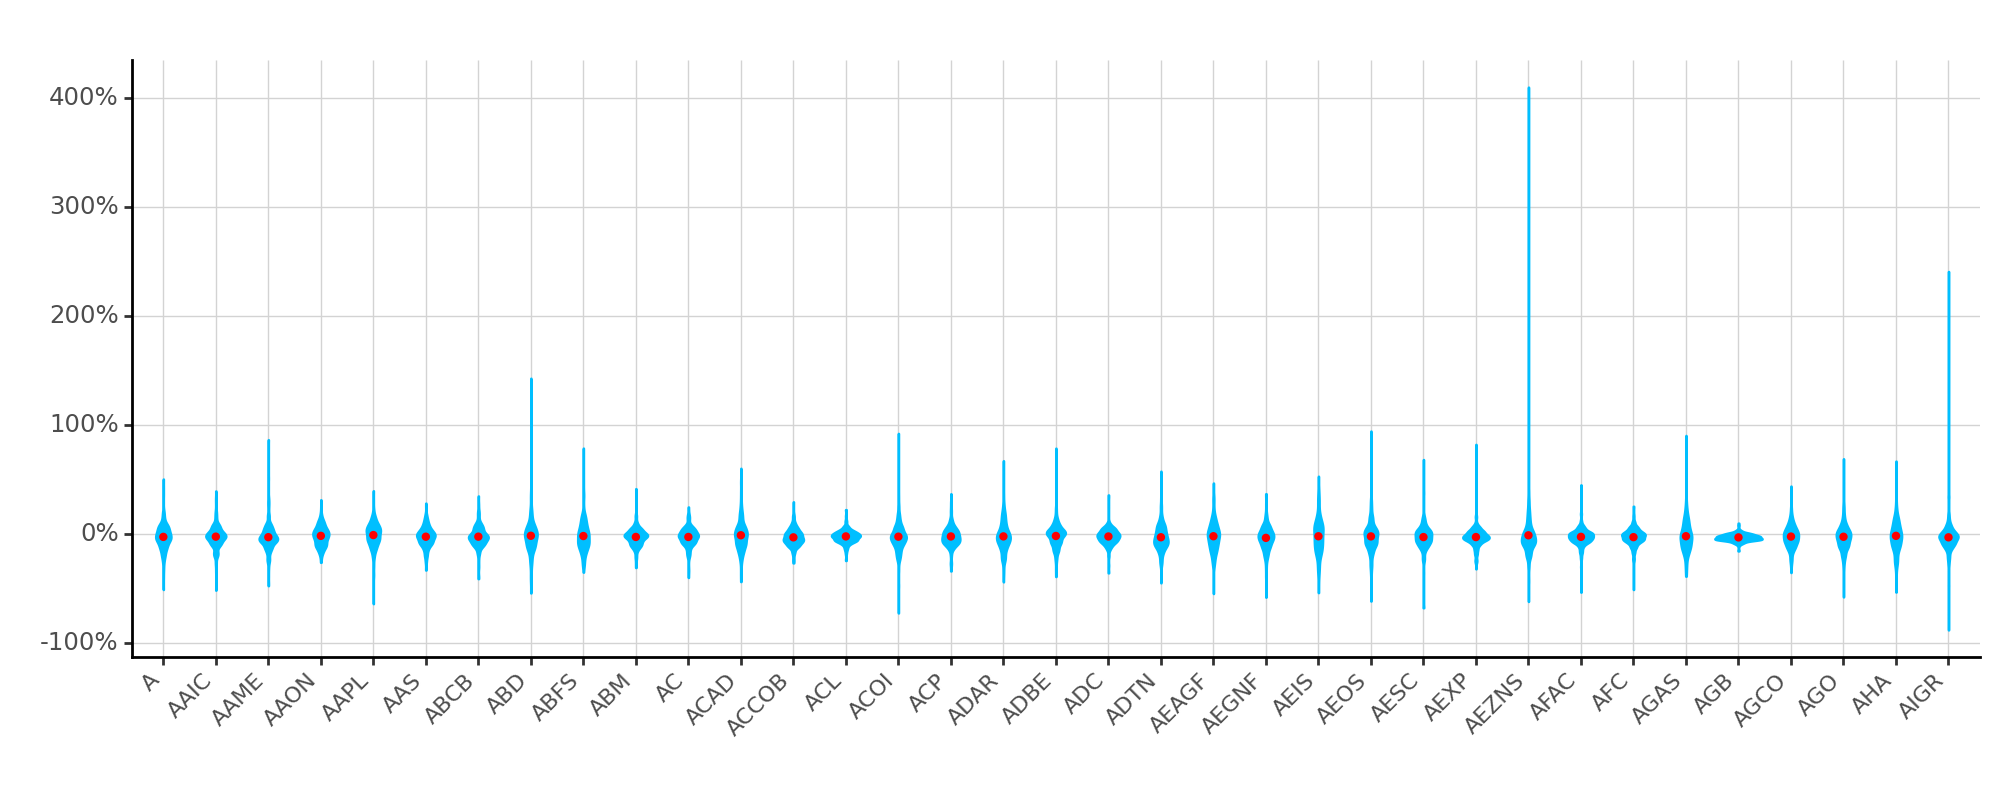

<Figure Size: (1000 x 400)>

In [36]:
df_des = data_dict['data_55']
df_violin = df_des[df_des['ticker'].isin(df_des['ticker'].unique()[:35])]
violin(df_violin)

In [37]:
macro_value1 = ['Month', 'Dividend- Price Ratio',
 'Dividend Yield',
 'Earnings Price Ratio',
 'Dividend Payout Ratio',
 'Stock Variance',
 'Book-to-Market Ratio',
 'Net Equity Expansion',
 'Treasury Bills (3 month)',
 'Long-Term Yield',
 'Long-Term Rate of Return',
 'Term Spread',
 'Default Yield Spread','Inflation']

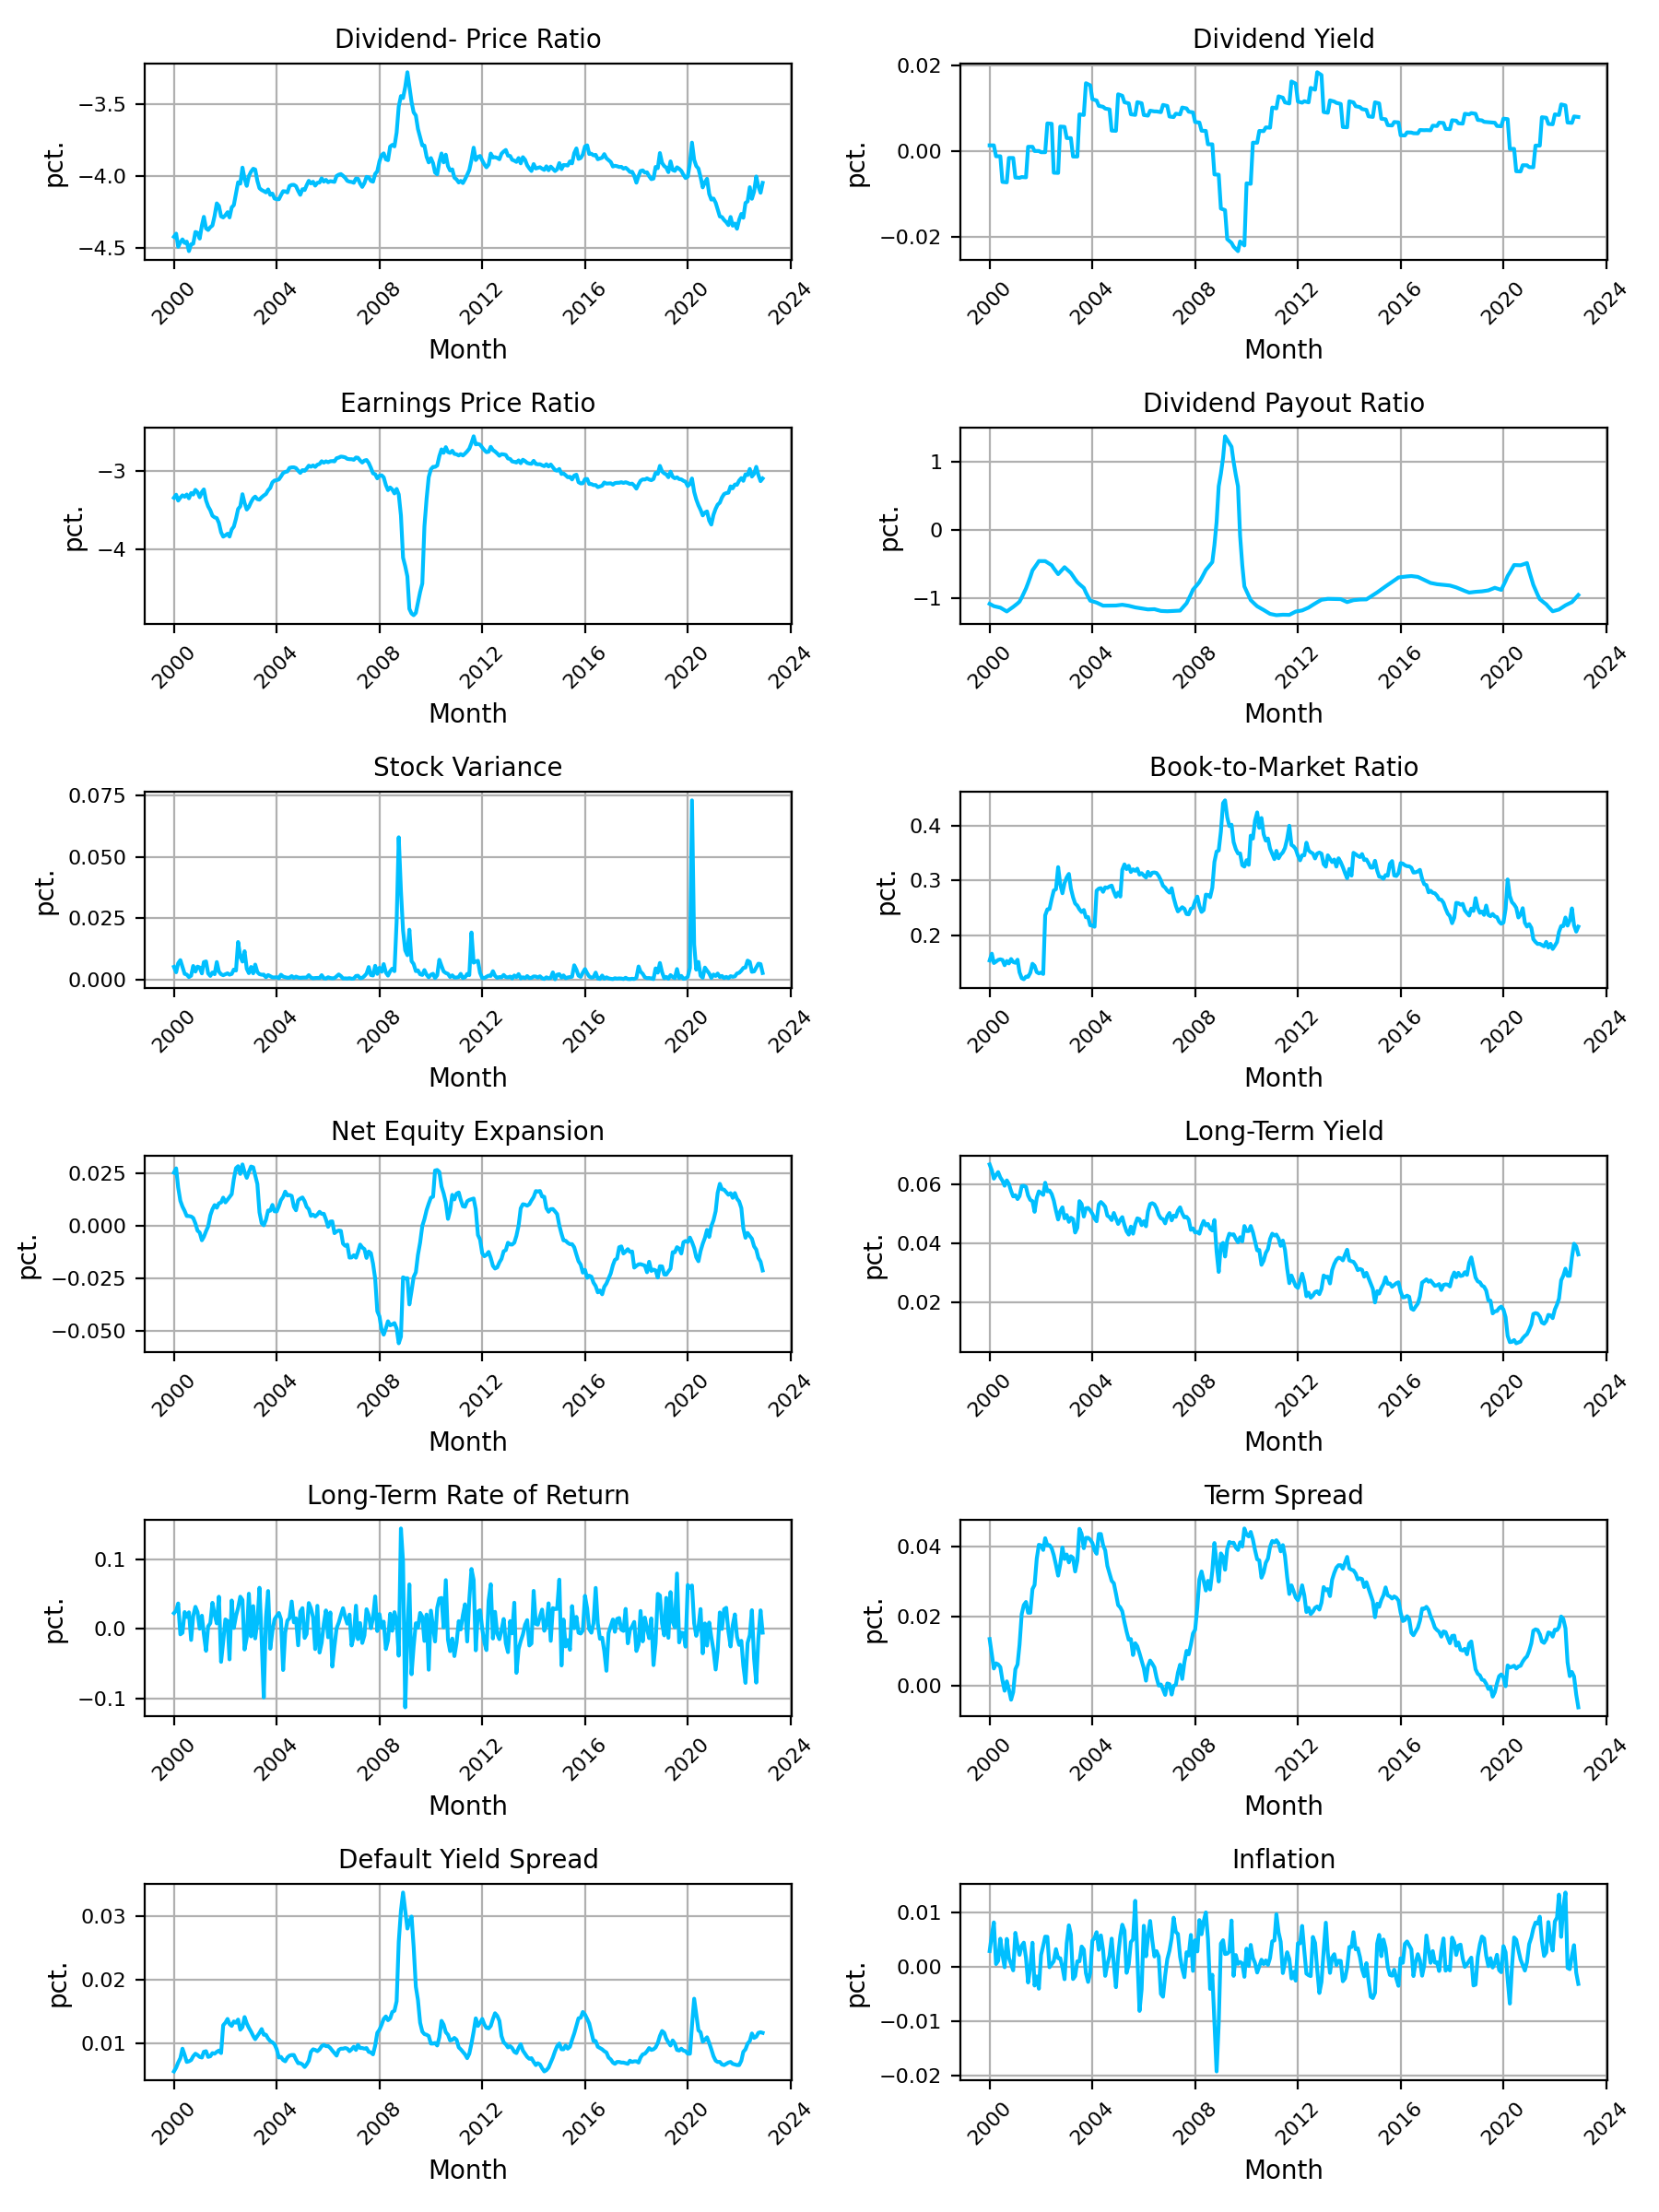

In [38]:
import matplotlib.pyplot as plt
import os
macro_predictors.columns = macro_value1
macro_predictors.set_index('Month', inplace=False)

# Get the list of macro predictor column names
predictor_columns = macro_predictors.columns.tolist()[1:]
predictor_columns.remove('Treasury Bills (3 month)')

# Calculate the number of rows and columns needed
num_plots = len(predictor_columns)
num_rows = (num_plots + 1) // 2  # Add 1 and use integer division to round up
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 2 * num_rows))
for i, predictor in enumerate(predictor_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.plot(macro_predictors['Month'], macro_predictors[predictor], color = "deepskyblue")
    ax.set_title(predictor, size = 10)
    ax.set_xlabel('Month')
    ax.set_ylabel('pct.')
    ax.tick_params(axis='x', labelsize=8, rotation = 45)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True)
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])
plt.tight_layout()
folder_name = "plots"
plt.savefig(os.path.join(folder_name, "macro_plots.png"))
plt.show()

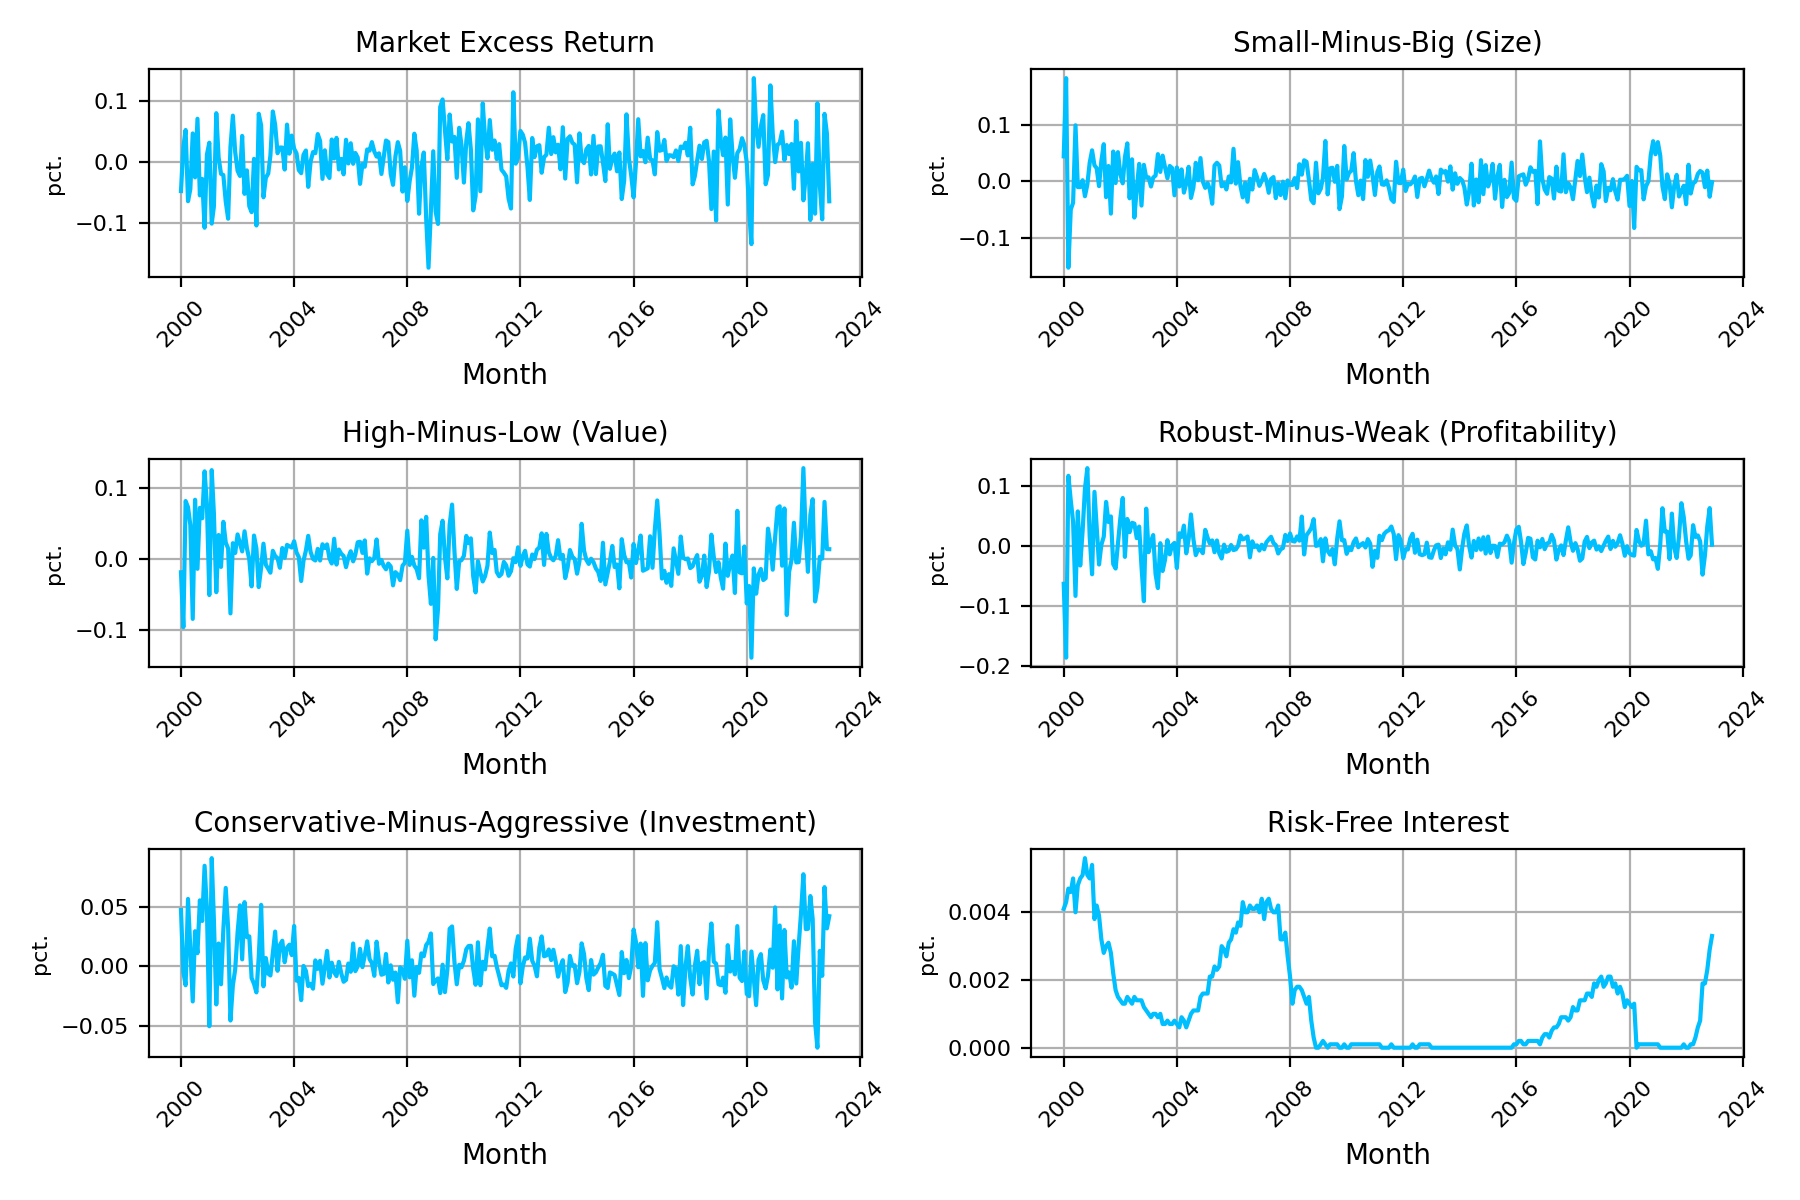

In [39]:
import matplotlib.pyplot as plt

#factors_ff5_monthly.set_index('factor_ff5_month', inplace=False)
factors_ff5_monthly.columns=['Month','Market Excess Return','Small-Minus-Big (Size)','High-Minus-Low (Value)','Robust-Minus-Weak (Profitability)','Conservative-Minus-Aggressive (Investment)','Risk-Free Interest']
# Get the list of macro predictor column names
predictor_columns_ff = factors_ff5_monthly.columns.tolist()[1:]

# Calculate the number of rows and columns needed
num_plots = len(predictor_columns_ff)
num_rows = (num_plots + 1) // 2  # Add 1 and use integer division to round up
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 2 * num_rows))
for i, predictor in enumerate(predictor_columns_ff):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.plot(factors_ff5_monthly['Month'], factors_ff5_monthly[predictor], color = "deepskyblue")
    ax.set_title(predictor, size = 10)
    ax.set_xlabel('Month')
    ax.set_ylabel('pct.', size = 8)
    ax.tick_params(axis='x', labelsize=8, rotation = 45)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True)
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])
plt.tight_layout()
folder_name = "plots"
plt.savefig(os.path.join(folder_name, "fama_plots.png"))
plt.show()